In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import xarray as xr

plt.rcParams['font.family'] = 'serif'

In [2]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('1986-01-01 00:00Z',
                              '1986-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.snapshots

DatetimeIndex(['1986-01-01 00:00:00', '1986-01-01 01:00:00',
               '1986-01-01 02:00:00', '1986-01-01 03:00:00',
               '1986-01-01 04:00:00', '1986-01-01 05:00:00',
               '1986-01-01 06:00:00', '1986-01-01 07:00:00',
               '1986-01-01 08:00:00', '1986-01-01 09:00:00',
               ...
               '1986-12-31 14:00:00', '1986-12-31 15:00:00',
               '1986-12-31 16:00:00', '1986-12-31 17:00:00',
               '1986-12-31 18:00:00', '1986-12-31 19:00:00',
               '1986-12-31 20:00:00', '1986-12-31 21:00:00',
               '1986-12-31 22:00:00', '1986-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [3]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    29059.0
2015-01-01 01:00:00+00:00    28663.0
2015-01-01 02:00:00+00:00    26626.0
2015-01-01 03:00:00+00:00    24778.0
2015-01-01 04:00:00+00:00    23212.0
Name: GBR, dtype: float64


In [4]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

Index(['load'], dtype='object')

In [5]:
network.loads_t.p_set

Load,load
snapshot,
1986-01-01 00:00:00,29059.0
1986-01-01 01:00:00,28663.0
1986-01-01 02:00:00,26626.0
1986-01-01 03:00:00,24778.0
1986-01-01 04:00:00,23212.0
...,...
1986-12-31 19:00:00,35944.0
1986-12-31 20:00:00,33128.0
1986-12-31 21:00:00,30488.0


In [6]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [7]:
# CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "offshorewind")
network.add("Carrier", "nuclear")

# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex * (1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_windOnshore.values)

# add offshore wind generator
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex *(1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshore,
            marginal_cost = 0,
            p_max_pu = CF_windOffshore.values)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add CCGT (Combine Cycle Gas Turbine) generator
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)

# add nuclear generator
capital_cost_nuclear = annuity(40,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=1000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

Index(['nuclear'], dtype='object')

In [8]:
network.generators_t.p_max_pu

Generator,offshorewind,onshorewind,solar
snapshot,,,
1986-01-01 00:00:00,0.676,0.220,0.0
1986-01-01 01:00:00,0.650,0.228,0.0
1986-01-01 02:00:00,0.604,0.233,0.0
1986-01-01 03:00:00,0.506,0.222,0.0
1986-01-01 04:00:00,0.416,0.210,0.0
...,...,...,...
1986-12-31 19:00:00,0.225,0.106,0.0
1986-12-31 20:00:00,0.187,0.110,0.0
1986-12-31 21:00:00,0.144,0.132,0.0


In [9]:
network.optimize(solver_name='gurobi', Outputflag = 0)

Index(['electricity bus'], dtype='object', name='Bus')


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Outputflag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 24.23it/s]
INFO:linopy.io: Writing time: 0.6s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2626576


INFO:gurobipy:Set parameter LicenseID to value 2626576


Academic license - for non-commercial use only - expires 2026-02-22


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-22


Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-_6rpncsg.lp


INFO:gurobipy:Read LP format model from file C:\Users\Dmora\AppData\Local\Temp\linopy-problem-_6rpncsg.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 96365 rows, 43805 columns, 170954 nonzeros


INFO:gurobipy:obj: 96365 rows, 43805 columns, 170954 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 1.94e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [10]:
print(network.objective/1000000) #in 10^6 €

19409.954693329193


In [11]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    68.782018
dtype: float64


In [12]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     58270.983213
offshorewind        0.000000
solar               0.000000
CCGT            46777.366906
nuclear             0.000000
Name: p_nom_opt, dtype: float64

<h2>Plot a week in winter</h2>

In [13]:
num_hours_week = 7 * 24

hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')
demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

C:\Users\Dmora\AppData\Local\Temp\ipykernel_30280\3807979031.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')


KeyError: "None of [DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',\n               '2015-01-01 02:00:00', '2015-01-01 03:00:00',\n               '2015-01-01 04:00:00', '2015-01-01 05:00:00',\n               '2015-01-01 06:00:00', '2015-01-01 07:00:00',\n               '2015-01-01 08:00:00', '2015-01-01 09:00:00',\n               ...\n               '2015-01-07 14:00:00', '2015-01-07 15:00:00',\n               '2015-01-07 16:00:00', '2015-01-07 17:00:00',\n               '2015-01-07 18:00:00', '2015-01-07 19:00:00',\n               '2015-01-07 20:00:00', '2015-01-07 21:00:00',\n               '2015-01-07 22:00:00', '2015-01-07 23:00:00'],\n              dtype='datetime64[ns]', length=168, freq='h')] are in the [index]"

<h2>Plot a week in summer</h2>

In [ ]:
num_hours_week = 7 * 24

hours = pd.date_range(start="2015-01-06", periods=num_hours_week, freq='H')
demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

plt.tight_layout()


C:\Users\Dmora\AppData\Local\Temp\ipykernel_37120\1647320593.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-06", periods=num_hours_week, freq='H')


<Figure size 640x480 with 0 Axes>

In [ ]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}


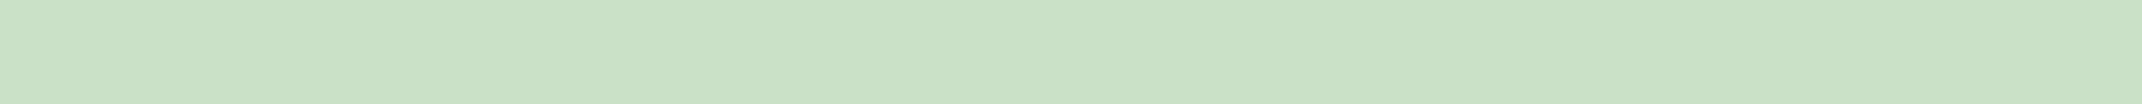

In [ ]:

# Task C: Interannual Variability

# Specify your desired range here:
start_year = 1990
end_year   = 2000

OFFSHORE WIND

In [ ]:
# OFFSHORE WIND
cf_gbr_offshore = df_offshore['GBR']
offshore_mean_per_year = cf_gbr_offshore.groupby(cf_gbr_offshore.index.year).mean()
offshore_var_per_year  = cf_gbr_offshore.groupby(cf_gbr_offshore.index.year).var()

print("Anual mean CF offshore wind:")
print(offshore_mean_per_year)
print("\nVariance  CF offshore wind:")
print(offshore_var_per_year)

# 3B. Estadísticas AGREGADAS (toda la serie)
print("\nMEAN:", cf_gbr_offshore.mean())
print("Variance :", cf_gbr_offshore.var())



Anual mean CF offshore wind:
utc_time
1979    0.320562
1980    0.333804
1981    0.325409
1982    0.309920
1983    0.333409
1984    0.300310
1985    0.312496
1986    0.365245
1987    0.278254
1988    0.325970
1989    0.308940
1990    0.357797
1991    0.297314
1992    0.327631
1993    0.314448
1994    0.346555
1995    0.335684
1996    0.317016
1997    0.292860
1998    0.353631
1999    0.336123
2000    0.331579
2001    0.304962
2002    0.314559
2003    0.290028
2004    0.309378
2005    0.316821
2006    0.314946
2007    0.321662
2008    0.341969
2009    0.306705
2010    0.265152
2011    0.325566
2012    0.312689
2013    0.327076
2014    0.324300
2015    0.348040
2016    0.302074
2017    0.320508
Name: GBR, dtype: float64

Variance  CF offshore wind:
utc_time
1979    0.053821
1980    0.055279
1981    0.054074
1982    0.058160
1983    0.059216
1984    0.055726
1985    0.050406
1986    0.064403
1987    0.048384
1988    0.054917
1989    0.054288
1990    0.066577
1991    0.057881
1992    0.0563

ONSHORE WIND

In [ ]:
# ONSHORE WIND
cf_gbr_onshore = df_onshorewind['GBR']
onshore_mean_per_year = cf_gbr_onshore.groupby(cf_gbr_onshore.index.year).mean()
onshore_var_per_year  = cf_gbr_onshore.groupby(cf_gbr_onshore.index.year).var()

print("Anual mean CF offshore wind:")
print(onshore_mean_per_year)
print("\nVariance  CF offshore wind:")
print(onshore_var_per_year)

# 3B. Estadísticas AGREGADAS (toda la serie)
print("\nMEAN:", cf_gbr_onshore.mean())
print("Variance :", cf_gbr_onshore.var())


Anual mean CF offshore wind:
utc_time
1979    0.259211
1980    0.253569
1981    0.258010
1982    0.266804
1983    0.275307
1984    0.238623
1985    0.243203
1986    0.300916
1987    0.223875
1988    0.260104
1989    0.265159
1990    0.299537
1991    0.248612
1992    0.275501
1993    0.257040
1994    0.291154
1995    0.263951
1996    0.254466
1997    0.239656
1998    0.281574
1999    0.269403
2000    0.257941
2001    0.233926
2002    0.248683
2003    0.235863
2004    0.253490
2005    0.264248
2006    0.250491
2007    0.256048
2008    0.271013
2009    0.255358
2010    0.208214
2011    0.239176
2012    0.221516
2013    0.242206
2014    0.234291
2015    0.260073
2016    0.216776
2017    0.236269
Name: GBR, dtype: float64

Variance  CF offshore wind:
utc_time
1979    0.031804
1980    0.030822
1981    0.031606
1982    0.035601
1983    0.040384
1984    0.033607
1985    0.027529
1986    0.037483
1987    0.028205
1988    0.032199
1989    0.034660
1990    0.043262
1991    0.035608
1992    0.0332

SOLAR

In [ ]:
# SOLAR
cf_gbr_solar = df_solar['GBR']
solar_mean_per_year = cf_gbr_solar.groupby(cf_gbr_solar.index.year).mean()
solar_var_per_year  = cf_gbr_solar.groupby(cf_gbr_solar.index.year).var()

print("Anual mean CF offshore wind:")
print(solar_mean_per_year)
print("\nVariance  CF offshore wind:")
print(solar_var_per_year)

# 3B. Estadísticas AGREGADAS (toda la serie)
print("\nMEAN:", cf_gbr_solar.mean())
print("Variance :", cf_gbr_solar.var())



Anual mean CF offshore wind:
utc_time
1979    0.096742
1980    0.093438
1981    0.089539
1982    0.099221
1983    0.094562
1984    0.100168
1985    0.091786
1986    0.096407
1987    0.095259
1988    0.094442
1989    0.101088
1990    0.098726
1991    0.095888
1992    0.092553
1993    0.093449
1994    0.097741
1995    0.104702
1996    0.095724
1997    0.099179
1998    0.088410
1999    0.094513
2000    0.093948
2001    0.096748
2002    0.093274
2003    0.106920
2004    0.091252
2005    0.091649
2006    0.096232
2007    0.095611
2008    0.096168
2009    0.096442
2010    0.102863
2011    0.102009
2012    0.101688
2013    0.103833
2014    0.104051
2015    0.103243
2016    0.103388
2017    0.097760
Name: GBR, dtype: float64

Variance  CF offshore wind:
utc_time
1979    0.022349
1980    0.022164
1981    0.020190
1982    0.024376
1983    0.022560
1984    0.024860
1985    0.020948
1986    0.023058
1987    0.022168
1988    0.021769
1989    0.024930
1990    0.024818
1991    0.022536
1992    0.0211

COMPARING 

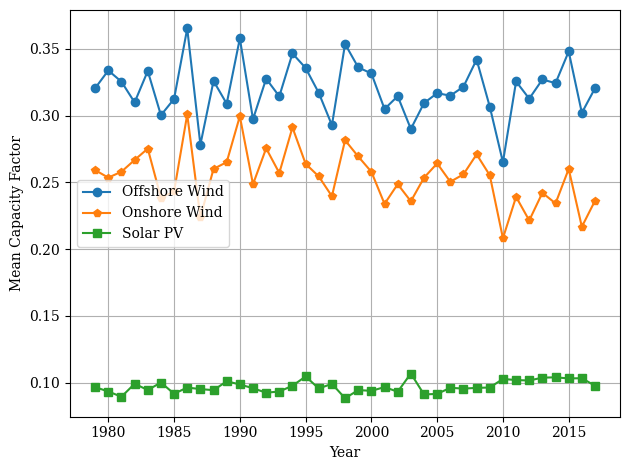

In [ ]:
# Plot series on the same figure
plt.figure()
offshore_mean_per_year.plot(marker='o', label='Offshore Wind')
onshore_mean_per_year.plot(marker='p', label='Onshore Wind')
solar_mean_per_year.plot(marker='s', label='Solar PV')
plt.xlabel('Year')
plt.ylabel('Mean Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

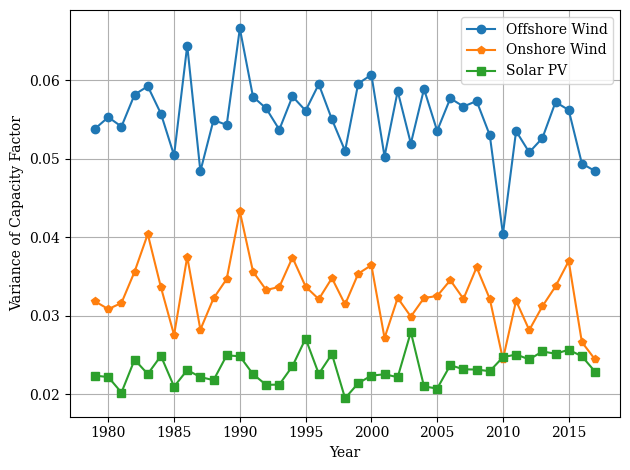

In [ ]:
# Plot series on the same figure
plt.figure()
offshore_var_per_year.plot(marker='o', label='Offshore Wind')
onshore_var_per_year.plot(marker='p', label='Onshore Wind')
solar_var_per_year.plot(marker='s', label='Solar PV')
plt.xlabel('Year')
plt.ylabel('Variance of Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
